In [1]:
!pip install timm

     |████████████████████████████████| 376 kB 4.9 MB/s 


In [2]:
import os
import sys
from glob import glob

import cv2
import warnings
import argparse
import random
import gc
import pandas as pd
from glob import glob
from tqdm import tqdm
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, random_split, Dataset

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from sklearn.model_selection import KFold, GroupKFold, train_test_split, StratifiedKFold
warnings.simplefilter('ignore')

In [3]:
train_path = glob("../input/petfinder-pawpularity-score/train/*.jpg")

In [4]:
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
train["file_path"] = train_path

In [5]:
class CatDogDataset(Dataset):

    def __init__(self, df, transforms, type_):
        self.type = type_
        self.df = df
        self.transforms = transforms
        self.file_names = df['file_path'].values
        if type_ != "test":
            self.labels = df["label"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        path = self.file_names[index]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image'].float()
        if self.type == "test":
            return image
        label = torch.tensor(self.labels[index]).long()
        return image, label

In [6]:
image_size = 384
def train_transforms():
    train_transform = A.Compose(
        [
            A.RandomResizedCrop(int(image_size), int(
                image_size), scale=(0.90, 1.0)),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ]
    )
    return train_transform

def valid_transforms():
    valid_transform = A.Compose(
        [
            A.Resize(image_size, image_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ]
    )
    return valid_transform

In [7]:
class Custom2DCNN(nn.Module):
    def __init__(self):
        super(Custom2DCNN, self).__init__()
        model_name = "tf_efficientnet_b1"
        backborn = timm.create_model(model_name, pretrained=True, in_chans=3)
        if 'efficientnet' in model_name:
            n_features = backborn.classifier.in_features
            backborn.classifier = nn.Identity()
            self.backborn = backborn
        else:
            n_features = list(backborn.children())[-1].in_features
            backborn = list(backborn.children())[:-1]
            self.backborn = torch.nn.Sequential(*backborn)
        self.fc = nn.Linear(n_features, 1)

    def forward(self, x):
        x = self.backborn(x)
        x = self.fc(x)
        return x

In [8]:
def test_fn(model, test_loader, device):
    model.eval()
    image_preds_all = []
    image_targets_all = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        image_preds = model(imgs).squeeze(1)  # output = model(input)
        image_preds_all += [np.where(image_preds.detach().cpu().numpy() < 0.5, 0, 1)]

    image_preds_all = np.concatenate(image_preds_all)
    return image_preds_all

In [9]:
state_dict = torch.load("../input/dog-cat-classifier/fold_0_7.pth")

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_dataset = CatDogDataset(train, valid_transforms(), 'test')
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=False,
    drop_last=False)
model = Custom2DCNN().to(device)
model.load_state_dict(state_dict)

train_preds = test_fn(model, test_loader, device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1_aa-ea7a6ee0.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b1_aa-ea7a6ee0.pth
100%|██████████| 620/620 [02:24<00:00,  4.29it/s]


In [11]:
train["pred_label"] = train_preds

In [12]:
import matplotlib.pyplot as plt

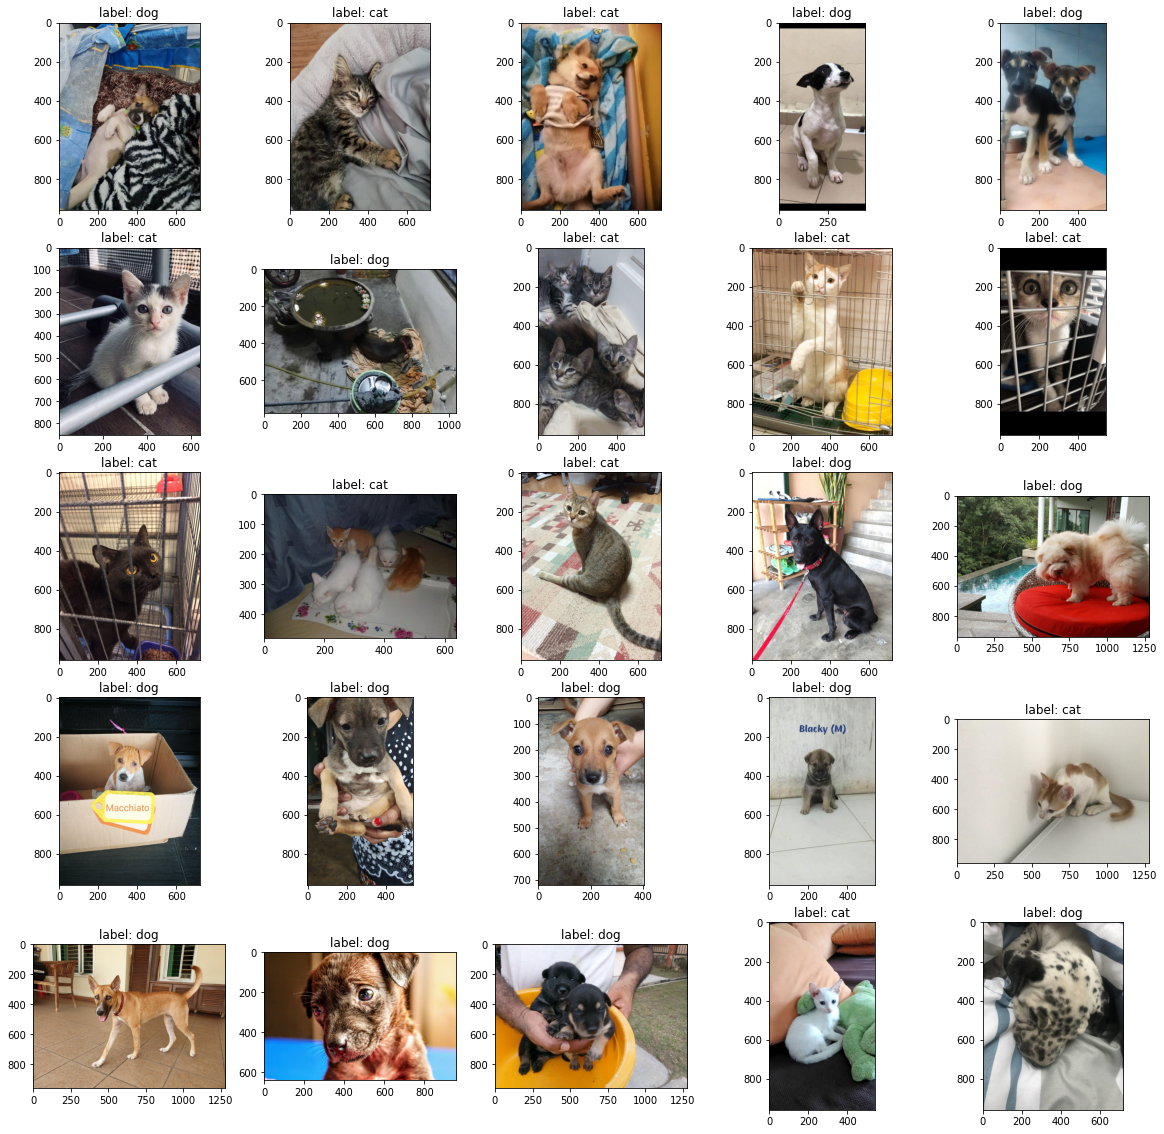

In [13]:
plt.figure(figsize=(20, 20))
row, col = 5, 5
for i in range(row * col):
    plt.subplot(col, row, i+1)
    image = cv2.imread(train.loc[i*5, 'file_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = train.loc[i*5, 'pred_label']
    if target == 0:
        target = "dog"
    else:
        target = "cat"
    plt.imshow(image)
    plt.title(f"label: {target}")
plt.show()

In [14]:
dog_df = train[train.pred_label == 0]
cat_df = train[train.pred_label == 1]

count    4703.000000
mean       38.068042
std        20.607130
min         1.000000
25%        25.000000
50%        33.000000
75%        47.000000
max       100.000000
Name: Pawpularity, dtype: float64


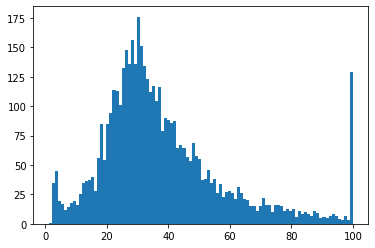

In [15]:
print(dog_df["Pawpularity"].describe())
plt.figure()
plt.hist(dog_df["Pawpularity"], bins=100)
plt.show()

count    5209.000000
mean       38.012862
std        20.580255
min         1.000000
25%        25.000000
50%        33.000000
75%        46.000000
max       100.000000
Name: Pawpularity, dtype: float64


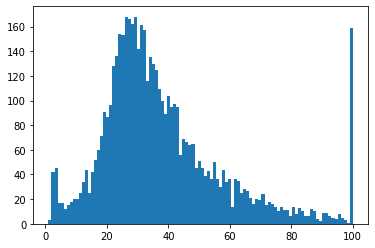

In [16]:
print(cat_df["Pawpularity"].describe())
plt.figure()
plt.hist(cat_df["Pawpularity"], bins=100)
plt.show()

In [17]:
train.to_csv('train_with_type.csv', index=False)